##Import Modules

In [ ]:
import os

import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

##Connect to Google Drive to explore Dataset

In [ ]:
from google.colab import drive
# drive.mount('/content/gdrive/', force_remount=True)
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


##Unzip the Zipped dataset 

In [ ]:
!unzip /content/gdrive/MyDrive/Tomato_dataset.zip > /dev/null

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Load and Explore DataSet

In [ ]:
os.chdir("/content/Tomato_dataset")
print(os.listdir())

TRAINING_DIR = os.path.join('/content/Tomato_dataset/train')
VALIDATION_DIR = os.path.join('/content/Tomato_dataset/val')
TESTING_DIR = os.path.join('/content/Tomato_dataset/test')

['test', 'val', 'train']


In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAINING_DIR,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 8715 files belonging to 10 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2902 files belonging to 10 classes.


In [ ]:
test_dataset = tf.keras.utils.image_dataset_from_directory(TESTING_DIR,
                                                           shuffle=False,
                                                           labels='inferred',
                                                           label_mode='categorical',
                                                           image_size=IMG_SIZE)

Found 2914 files belonging to 10 classes.


##Display Diseases in Dataset

In [ ]:
class_names = train_dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'Two_spotted_spider_mite']

##Summarize Dataset

In [ ]:
categories = []
train = []
val = []
test = []

folders = os.listdir('/content/Tomato_dataset/train')
for f in folders:
    categories.append(f)
    train.append(len(os.listdir(os.path.join('/content/Tomato_dataset/train', f))))

folders = os.listdir('/content/Tomato_dataset/val')
for f in folders:
    val.append(len(os.listdir(os.path.join('/content/Tomato_dataset/val', f))))

folders = os.listdir('/content/Tomato_dataset/val')
for f in folders:
    test.append(len(os.listdir(os.path.join('/content/Tomato_dataset/test', f))))

data_count = pd.DataFrame({'categories': categories,
                     'train': train,
                     'val': val,
                     'test': test                     
                    })

data_count

,categories,train,val,test
0,Bacterial_spot,1021,340,341
1,Septoria_leaf_spot,850,283,284
2,Tomato_Yellow_Leaf_Curl_Virus,2571,857,858
3,Early_blight,480,160,160
4,Healthy,763,254,255
5,Leaf_Mold,457,152,153
6,Target_Spot,674,224,226
7,Late_blight,916,305,307
8,Two_spotted_spider_mite,804,268,269
9,Tomato_mosaic_virus,179,59,61


##Visualize data for each of the classes

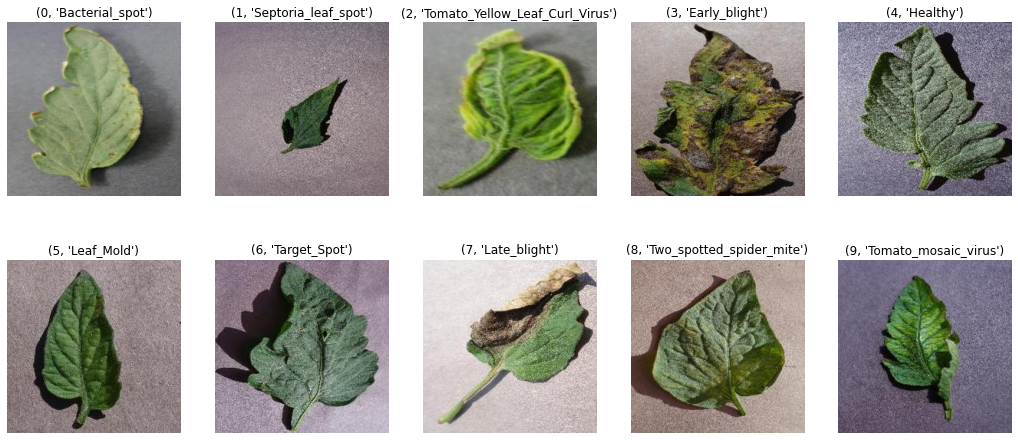

In [ ]:
classes = os.listdir('./train')

plt.figure(figsize=(18,8))

for i in enumerate(classes):
    pic = os.listdir('./train/'+i[1])[0]
    image = Image.open('./train/'+i[1]+'/'+pic)
    image = np.asarray(image)
    plt.subplot(2, 5, i[0]+1)
    plt.title(i)
    plt.imshow(image)
    plt.axis("off")
plt.show()

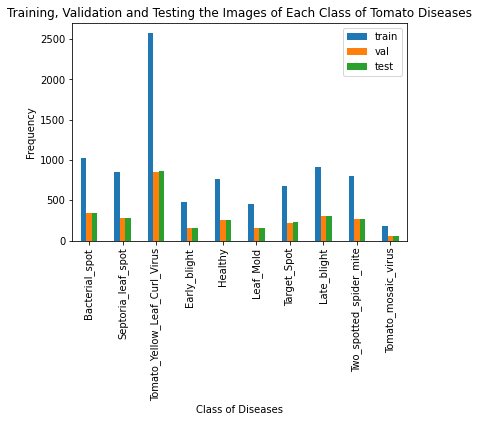

In [ ]:
data_count.plot.bar(x='categories', title="Training, Validation and Testing the Images of Each Class of Tomato Diseases")
plt.xlabel('Class of Diseases')
plt.ylabel('Frequency')
plt.show()

##Configure the dataset using AUTOTUNE to automatically tune the mapping function to increase parallel processing efficiency


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

##Data Augmentation

In [ ]:
def data_augmentation(x):
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomContrast(factor=0.2),
    ])(x)

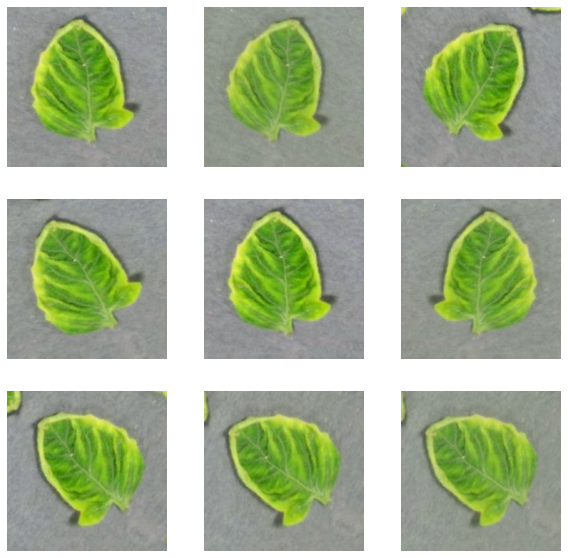

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Extract Base Feature using CNN - VGGNet Model

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
base_model.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def preprocess_input(x): 
    return tf.keras.layers.Rescaling(1./255, offset=-1)(x)


def feature_extractor(x):
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    return x


def classifier(x):
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(264, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x


def prediction_layer(x):
    return tf.keras.layers.Dense(10, activation='softmax')(x)
  
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = feature_extractor(x)
x = classifier(x)

outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


273/273 [==============================] - 109s 354ms/step - loss: 2.0825 - accuracy: 0.2902 - val_loss: 1.8839 - val_accuracy: 0.3050
Epoch 2/10
273/273 [==============================] - 94s 343ms/step - loss: 1.8504 - accuracy: 0.3619 - val_loss: 1.6102 - val_accuracy: 0.4966
Epoch 3/10
273/273 [==============================] - 95s 346ms/step - loss: 1.6562 - accuracy: 0.4384 - val_loss: 1.4628 - val_accuracy: 0.5362
Epoch 4/10
273/273 [==============================] - 94s 343ms/step - loss: 1.5116 - accuracy: 0.4944 - val_loss: 1.3601 - val_accuracy: 0.5910
Epoch 5/10
273/273 [==============================] - 95s 346ms/step - loss: 1.4139 - accuracy: 0.5255 - val_loss: 1.2214 - val_accuracy: 0.6258
Epoch 6/10
273/273 [==============================] - 93s 341ms/step - loss: 1.3337 - accuracy: 0.5501 - val_loss: 1.1603 - val_accuracy: 0.6258
Epoch 7/10
273/273 [==============================] - 94s 345ms/step - loss: 1.2717 - accuracy: 0.5719 - val_loss: 1.0914 - val_accuracy: 0.

##Plotting the Learning Curve

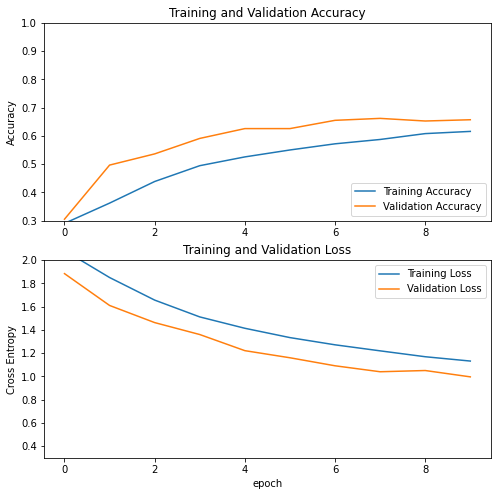

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.3,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0.3,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 10

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


##Compiling the Model

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             

##Add Callbacks

In [ ]:
os.getcwd()

'/content/Tomato_dataset'

In [ ]:
os.chdir("/content")

checkpoint = ModelCheckpoint('./vgg16_NN.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
log_csv = CSVLogger('./vgg16_NN_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint, early_stop, log_csv]

## Model Training Continues

In [ ]:
fine_tune_epochs = 80
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=callbacks_list)

Epoch 10/90
273/273 [==============================] - ETA: 0s - loss: 0.4092 - accuracy: 0.8562
Epoch 10: val_loss improved from 0.43712 to 0.35581, saving model to ./vgg16_NN.hdf5
273/273 [==============================] - 116s 422ms/step - loss: 0.4092 - accuracy: 0.8562 - val_loss: 0.3558 - val_accuracy: 0.8835
Epoch 11/90
273/273 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.8809
Epoch 11: val_loss did not improve from 0.35581
273/273 [==============================] - 115s 421ms/step - loss: 0.3494 - accuracy: 0.8809 - val_loss: 0.4424 - val_accuracy: 0.8473
Epoch 12/90
273/273 [==============================] - ETA: 0s - loss: 0.3050 - accuracy: 0.8967
Epoch 12: val_loss improved from 0.35581 to 0.25203, saving model to ./vgg16_NN.hdf5
273/273 [==============================] - 114s 418ms/step - loss: 0.3050 - accuracy: 0.8967 - val_loss: 0.2520 - val_accuracy: 0.9221
Epoch 13/90
273/273 [==============================] - ETA: 0s - loss: 0.2692 - accura

## Plotting the New Learning Curve

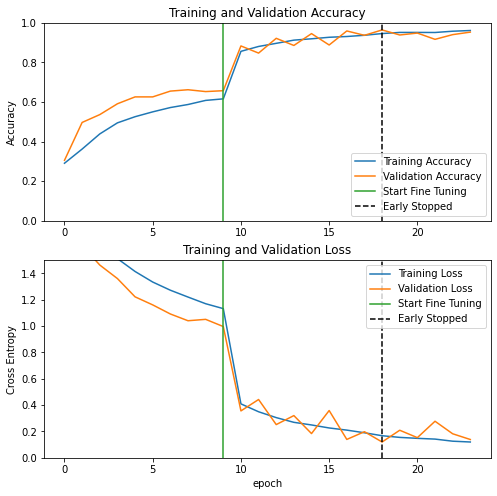

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([len(acc)-6, len(acc)-6], plt.ylim(),
         label='Early Stopped', linestyle='--', color='black')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.show()

In [ ]:
os.chdir("/content/Tomato_dataset")

CLASSES = []

folders = os.listdir(TESTING_DIR)
for f in folders:
    CLASSES.append(f)
    
CLASSES

['Bacterial_spot',
 'Septoria_leaf_spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Early_blight',
 'Healthy',
 'Leaf_Mold',
 'Target_Spot',
 'Late_blight',
 'Two_spotted_spider_mite',
 'Tomato_mosaic_virus']

##Prediction

In [ ]:
predictions = np.array([])
labels =  np.array([])

for x, y in test_dataset:
    predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
    labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

1/1 [==============================] - 1s 852ms/step


##Evaluation

Evaluating the Algorithm

Accuracy: 		 0.9526424159231297
Precision: 		 0.9554669278795497
Recall: 		 0.9526424159231297
F1 score: 		 0.9526424159231297 



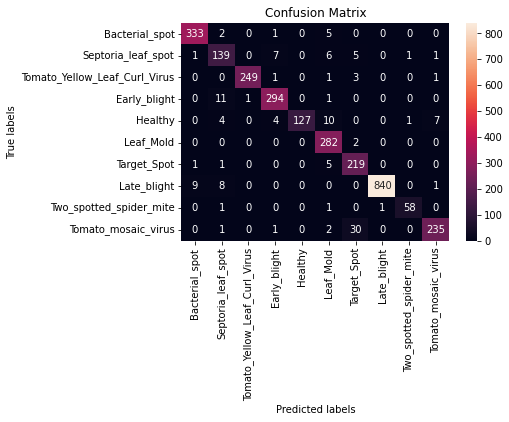

In [ ]:
print('Evaluating the Algorithm\n')
print('Accuracy: \t\t', accuracy_score(labels, predictions))
print('Precision: \t\t', precision_score(labels, predictions, average='weighted'))
print('Recall: \t\t', recall_score(labels, predictions, average='weighted'))
print('F1 score: \t\t', f1_score(labels, predictions, average='micro'), '\n')

# Confusion Matrix
cf = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

ax= plt.subplot()
sns.heatmap(cf, annot=True, fmt='g', ax=ax);

ax.set_title('Confusion Matrix'); 

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.xaxis.set_ticklabels(CLASSES); 
ax.yaxis.set_ticklabels(CLASSES);

plt.xticks(rotation = 90)
plt.yticks(rotation = 360)

plt.show()

In [ ]:
from google.colab import files
files.download("/content/vgg16_NN.hdf5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("/content/vgg16_NN_logs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>